In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import pydot

In [2]:
img_label_file = "data/labels.csv"

labels_csv = pd.read_csv(img_label_file, index_col=0)
labels = labels_csv.loc["fall-01"]
label_1 = labels.loc[labels["frame"] == 1]
label_1.label

fall name
fall-01   -1
Name: label, dtype: int64

In [3]:
!pip3 install pydot

Defaulting to user installation because normal site-packages is not writeable


In [4]:
### Read in the data
img_data_dir = "data/images/" # replace with your own dir if necessary
img_label_file = "data/labels.csv"

## Given an image name, extracts the label from the labels.csv file. True if 1 False if -1
def extract_label(file_name):
    split = file_name.split("-") # split image name
    fall_name = split[0] + "-" + split[1] # reconstruct fall name
    frame = int(split[-1].split(".")[0]) # end of split is like 113.png. removes .png part
    fall_labels = labels_csv.loc[fall_name]
    frame_label = fall_labels.loc[fall_labels["frame"] == frame]
    return int(frame_label.label) > 0

### Loads in the data from images and stores it in an array. Order is important because 
### The labels are in the same order as the images are appended to the array
def load_img_data():
    imgs = []
    labels = []
    labels_csv = pd.read_csv(img_label_file)
    
    # Iterates through fall folders and the frames within each fall
    for img_folder in os.listdir(img_data_dir):
        path = os.path.join(img_data_dir,img_folder)
        if ("fall" in path and "zip" not in path):
            for file in os.listdir(path):
                img = cv2.imread(os.path.join(path, file))
                img = cv2.resize(img ,(224,224))
                img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                imgs.append(img)
                labels.append([extract_label(file)])
                
    return imgs, labels

In [5]:
images, labels = load_img_data()

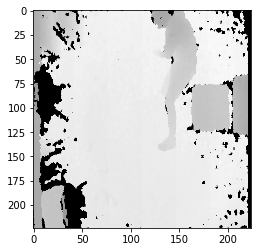

In [6]:
import matplotlib.pyplot as plt
plt.imshow(images[0])

Using TensorFlow backend.


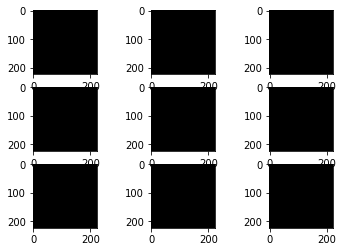

In [7]:
# example of random rotation image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = images[0]
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [8]:
from sklearn.model_selection import train_test_split
images = np.asarray(images)
labels = np.asarray(labels)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33)


In [9]:
# starter model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [10]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

#datagen.fit has to take in array of rank 4
datagen.fit(X_train)

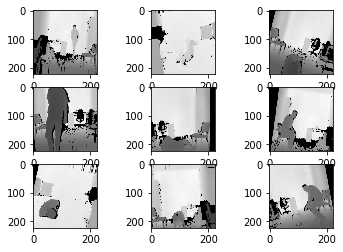

In [12]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=32):
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(224, 224, 3))
    # show the plot
    pyplot.show()
    break

In [13]:
model2 = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch = len(X_train)/32, epochs=10)

Epoch 1/10
126/125 [==============================] - 44s 351ms/step - loss: 1.0361 - accuracy: 0.6840
Epoch 2/10
126/125 [==============================] - 43s 345ms/step - loss: 0.6307 - accuracy: 0.6870
Epoch 3/10
126/125 [==============================] - 44s 345ms/step - loss: 0.5956 - accuracy: 0.6865
Epoch 4/10
126/125 [==============================] - 44s 347ms/step - loss: 0.5777 - accuracy: 0.6950
Epoch 5/10
126/125 [==============================] - 43s 345ms/step - loss: 0.5674 - accuracy: 0.6992
Epoch 6/10
126/125 [==============================] - 43s 345ms/step - loss: 0.5622 - accuracy: 0.7010
Epoch 7/10
126/125 [==============================] - 43s 343ms/step - loss: 0.5624 - accuracy: 0.7007
Epoch 8/10
126/125 [==============================] - 43s 344ms/step - loss: 0.5543 - accuracy: 0.7109
Epoch 9/10
126/125 [==============================] - 44s 346ms/step - loss: 0.5489 - accuracy: 0.7177
Epoch 10/10
126/125 [==============================] - 43s 342ms/step - l

In [14]:
model.evaluate(X_test, y_test)

1977/1977 [==============================] - 5s 3ms/step


[0.5255508137792424, 0.7511380910873413]

In [ ]:
y_pred = model.predict(X_test)

In [15]:
np.save("y_pred_cnn_data_aug", y_pred)
np.save("y_test_cnn_data_aug", y_test)

In [ ]:
y_pred_edited = y_pred > 0.5

print(y_pred_edited[:10])
print(y_test[:10])

test = np.where(y_pred_edited != y_test)
incorrect_indices = test[0]

# y_pred_edited != y_test

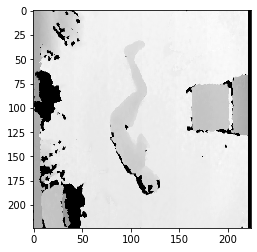

Image is [ True]but was misclassified as [False]


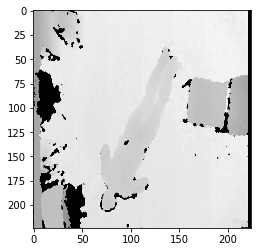

Image is [ True]but was misclassified as [False]


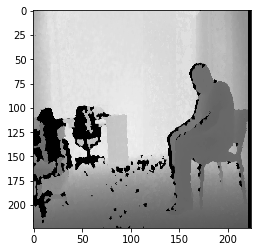

Image is [False]but was misclassified as [ True]


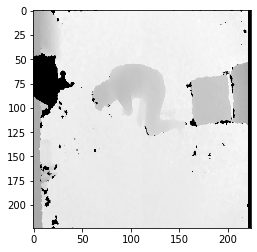

Image is [ True]but was misclassified as [False]


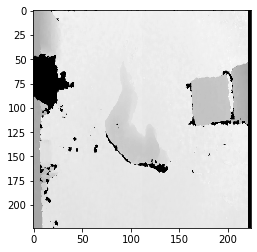

Image is [ True]but was misclassified as [False]


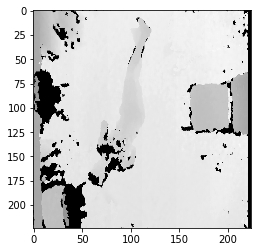

Image is [ True]but was misclassified as [False]


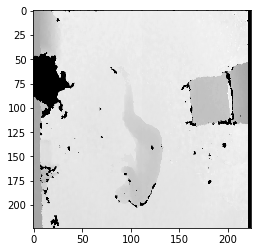

Image is [ True]but was misclassified as [False]


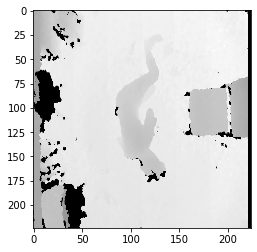

Image is [ True]but was misclassified as [False]


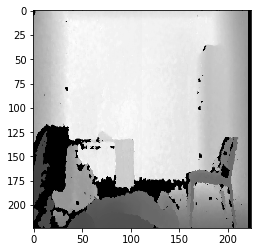

Image is [False]but was misclassified as [ True]


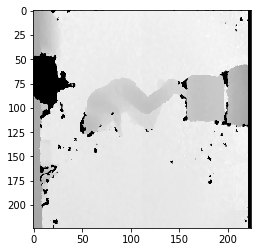

Image is [ True]but was misclassified as [False]


In [42]:
import matplotlib.pyplot as plt

index = incorrect_indices[0]

plt.imshow(X_test[index])
y_test[index]

for index in incorrect_indices[:10]:
    plt.imshow(X_test[index])
    plt.show()
    print("Image is " + str(y_test[index]) + "but was misclassified as " + str(y_pred_edited[index]))

In [17]:
# false - not a fall , True - a fall
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

       False       0.79      0.92      0.85      1382
        True       0.71      0.44      0.55       595

    accuracy                           0.78      1977
   macro avg       0.75      0.68      0.70      1977
weighted avg       0.77      0.78      0.76      1977



In [21]:
y_test_matrix = []
for i in y_test:
    y_test_matrix.append(i[0])
    
y_pred_matrix = []
y_pred_bool = y_pred > 0.5
for i in y_pred_bool:
    y_pred_matrix.append(i[0])

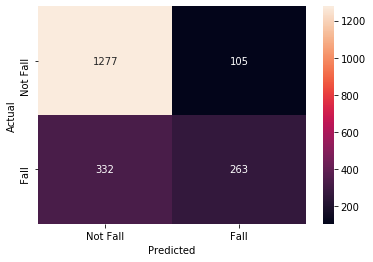

In [20]:
import seaborn as sn
data = {'y_Actual':   y_test_matrix,
        'y_Predicted': y_pred_matrix
        }
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])


sn.heatmap(confusion_matrix,xticklabels=['Not Fall', 'Fall'], yticklabels=[ 'Not Fall', ' Fall'],fmt='g', annot=True)
plt.show()

In [44]:
sample_data_dir = "samples"
def load_sample_data():
    imgs = []
    labels = []
    
    # Iterates through fall folders and the frames within each fall
    for img in os.listdir(sample_data_dir):
        file = os.path.join(sample_data_dir,img)
        # print(file)
        if ("png" not in file):
            continue
        img = cv2.imread(file)
        # print(file)
        img = cv2.resize(img ,(224,224))
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        imgs.append(img)
        if ("fall" in file):
            labels.append(1)
        else:
            labels.append(0)
            
                
    return imgs, labels

In [50]:
imgs, labels = load_sample_data()
imgs = np.asarray(imgs)
labels = np.asarray(labels)

predictions = model.predict(imgs)
# model.evaluate(imgs, labels)

predictions = predictions > 0.5
print(predictions)

print(labels)

[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]
[1 0 1 1 1 0 1 1 1 0]


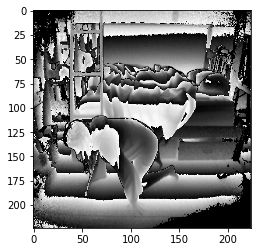

Image is classified by model as:[False]


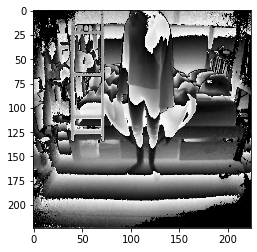

Image is classified by model as:[False]


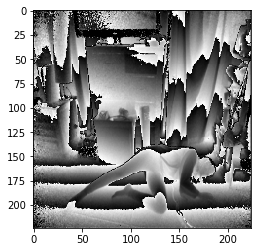

Image is classified by model as:[False]


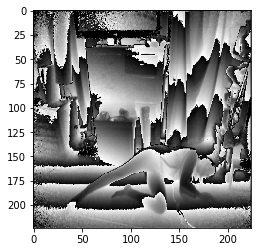

Image is classified by model as:[False]


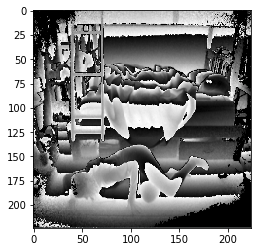

Image is classified by model as:[False]


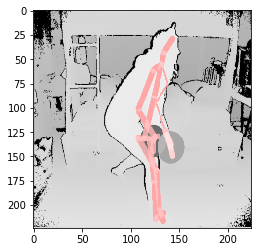

Image is classified by model as:[False]


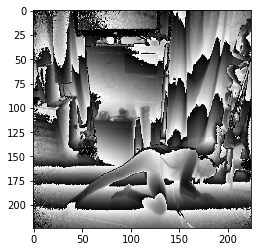

Image is classified by model as:[False]


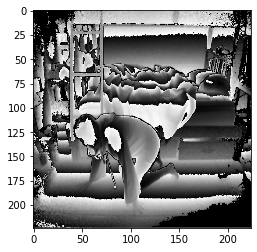

Image is classified by model as:[False]


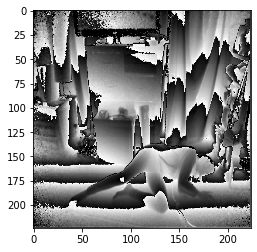

Image is classified by model as:[False]


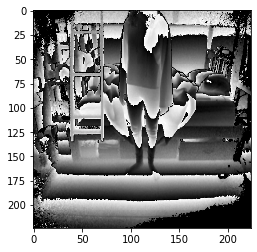

Image is classified by model as:[False]


In [52]:
import matplotlib.pyplot as plt

for i, img in enumerate(imgs):
    plt.imshow(img)
    plt.show()
    print("Image is classified by model as:" + str(predictions[i]))